In [7]:
from pytorch3d.io import load_ply
import open3d as o3d

# mesh_file = "chap1/ply_io/cube.ply"
mesh_file = "./data/cow.ply"
print(f"Visualizing the mesh using Open3D")
mesh = o3d.io.read_triangle_mesh(mesh_file)

o3d.visualization.draw_geometries(
    [mesh], 
    mesh_show_wireframe = True, 
    mesh_show_back_face = True
)

print("Loading the same file with Pytorch3D")

vertices, faces = load_ply(mesh_file)

print(f"Type of Vertices: {type(vertices)}")
print(f"Type of Faces: {type(faces)}")

# print(f"Vertices:\n{vertices}")
# print(f"Faces:\n{faces}")

print(f"Vertices:\n{vertices.shape}")
print(f"Faces:\n{faces.shape}")

Visualizing the mesh using Open3D
Loading the same file with Pytorch3D
Type of Vertices: <class 'torch.Tensor'>
Type of Faces: <class 'torch.Tensor'>
Vertices:
torch.Size([2903, 3])
Faces:
torch.Size([5804, 3])


In [9]:
# Mandatory Imports
import open3d as o3d
import torch
import pytorch3d
from pytorch3d.io import load_obj
from scipy.spatial.transform import Rotation as Rotation
from pytorch3d.renderer.cameras import PerspectiveCameras

# Load and visualize with Open3d
mesh_file = "./data/cube.obj"
mesh = o3d.io.read_triangle_mesh(mesh_file)
# o3d.visualization.draw_geometries(
#     [mesh],
#     mesh_show_wireframe = True,
#     mesh_show_back_face = True
# )

# Define a mini batch of 8 cameras
image_size = torch.ones(8,2)
image_size[:,0] = image_size[:,0] * 1024
image_size[:,1] = image_size[:,1] * 512
image_size = image_size.cuda()

focal_length = torch.ones(8,2)
focal_length[:,0] = focal_length[:,0] * 1200
focal_length[:,1] = focal_length[:,1] * 300
focal_length = image_size.cuda()

principal_point = torch.ones(8, 2)
principal_point[:,0] = principal_point[:,0] * 512
principal_point[:,1] = principal_point[:,1] * 256
principal_point = principal_point.cuda()

# define rotation for each camera
R = Rotation.from_euler("zyx",
                        [[n*5, n, n] for n in range(-4,4,1)],
                        degrees=True)
R = R.as_matrix()
R = torch.from_numpy(R).cuda()
# define translation for each camera
T = [ [n,0,0] for n in range(-4,4,1) ]
T = torch.FloatTensor(T).cuda()

# Defining camera properties using pytorch3D
camera = PerspectiveCameras(
    focal_length = focal_length,
    principal_point = principal_point,
    in_ndc = False, 
    image_size = image_size, 
    R = R, 
    T = T, 
    device = 'cuda'
)

# World to view Transformation
world_to_view_transform = camera.get_world_to_view_transform()

# World to screen Transformation
world_to_screen_transform = camera.get_full_projection_transform()

# Load meshes using Pytorch3D
vertices, faces, aux = load_obj(mesh_file)
vertices = vertices.cuda()

world_to_view_vertices = world_to_view_transform.transform_points(vertices)
world_to_screen_vertices = world_to_screen_transform.transform_points(vertices)

print(f"World to View Vertices:\n{world_to_view_vertices.shape}\n")

print(f"World to Screen Vertices:\n{world_to_screen_vertices.shape}\n")

World to View Vertices:
torch.Size([8, 8, 3])

World to Screen Vertices:
torch.Size([8, 8, 3])



# Rendering

### Rasterization
```python
pytorch3d.renderer.mesh.rasterize_meshes.rasterize_meshes
```
- The above function computes 4 things: 
  - `pix_to_face` : list of face indices that the ray may intersect. 
  - `zbuf` : list of depth values for these faces. 
  - `bary_coords` : barycentric coordinates of intersection point between the *face* and the *ray*
  - `pix_dists` : a list of signed distances between pixels (x and y) and the nearest point on all the faces where the ray intersects. The values can be negative since it contains signed distances. 

 

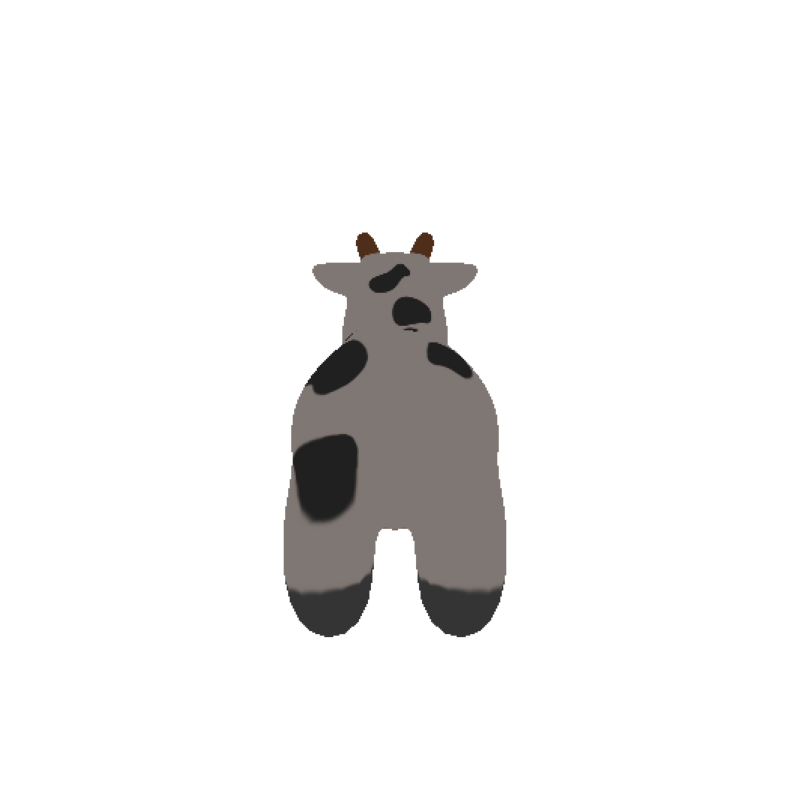

In [36]:
# Importing Modules
import open3d as o3d
import os
import sys
import torch
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras, 
    PointLights,
    Materials,
    RasterizationSettings,
    MeshRasterizer,
    MeshRenderer
)
from pytorch3d.renderer.mesh.shader import HardPhongShader
sys.path.append(os.path.abspath(''))


# Data Loader
data_dir = "./data"
obj_filename = os.path.join(data_dir, "cow_mesh/cow.obj")
device = torch.device("cuda")
mesh = load_objs_as_meshes(
    [obj_filename],
    device=device
)

# # Data Visualization (Using Open3D) {NOTE: Uncomment to see what the mesh looks like}
# mesh = o3d.io.read_triangle_mesh(obj_filename)
# o3d.visualization.draw_geometries(
#     [mesh],
#     mesh_show_wireframe = True,
#     mesh_show_back_face = True
# )

# Defining cameras and light sources. {NOTE: Light source placed in front of the }
R, T = look_at_view_transform(2.0, 0.0, 0)
cameras = PerspectiveCameras(R=R, T=T, device=device)
lights = PointLights(device=device, location=[[0.0,0.0,-3.0]]) 

# Rasterization Settings
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1
)

# Renderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader= HardPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

# Obtaining the Rendering Results
images = renderer(mesh)
plt.figure(figsize=(10,10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.savefig("light_at_front.png")
plt.show()

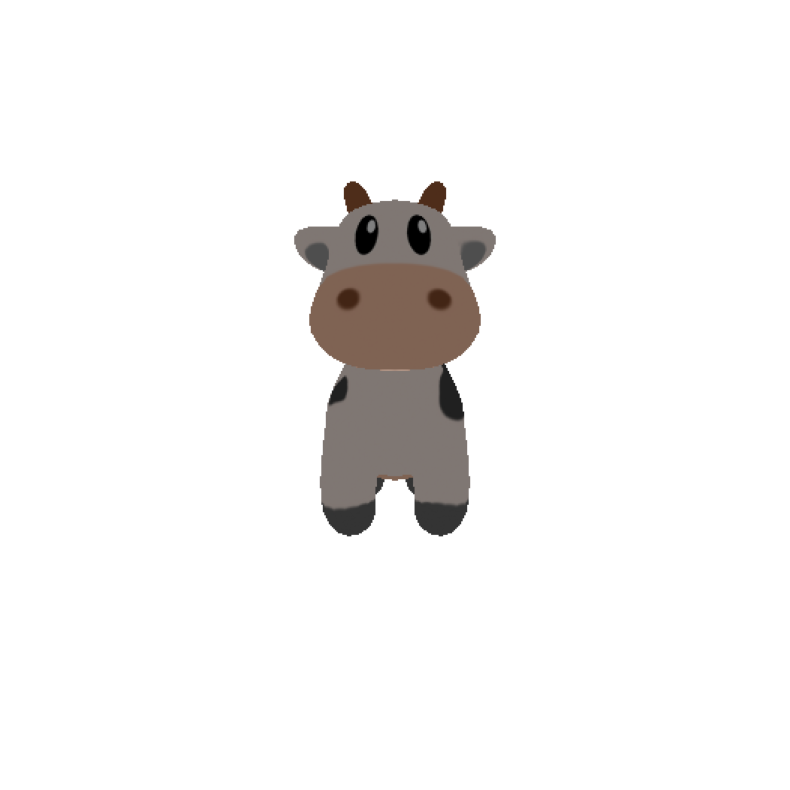

In [11]:
# Changing the Location of the Light Source
lights.location = torch.tensor([[0.0, 0.0, 3.0]], device=device)

# Obtaining the Rendering Results
images = renderer(mesh)
plt.figure(figsize=(10,10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.savefig("light_at_front.png")
plt.show()

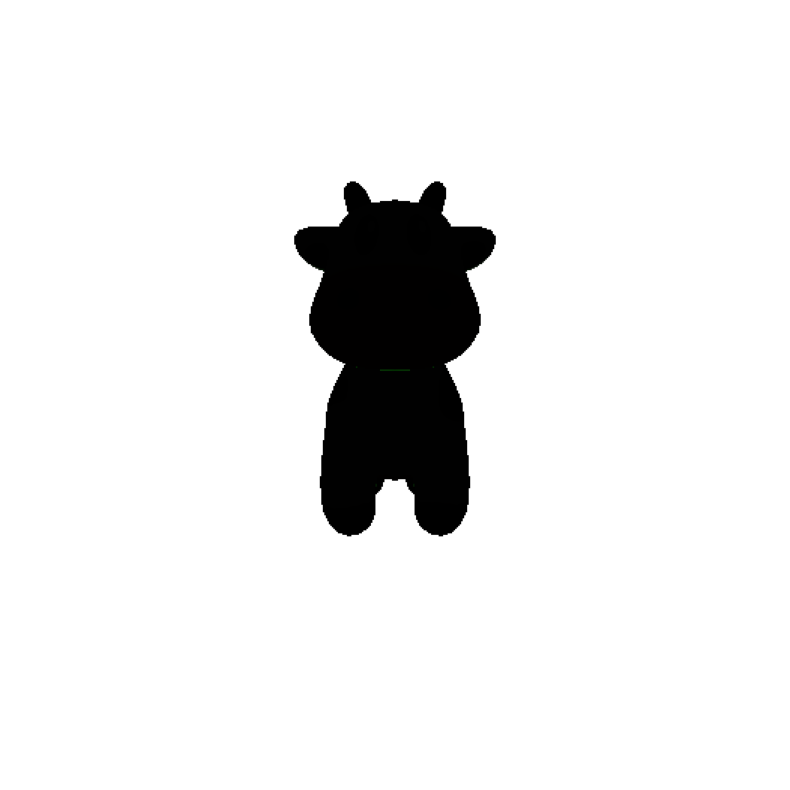

In [12]:
# Defining Materials
materials = Materials(
    device=device, 
    specular_color=[ [ 0.0, 1.0, 0.0 ] ], 
    shininess=10.0,
    ambient_color=( (0.01, 0.01, 0.01), ),
)

images = renderer(mesh, lights=lights, materials=materials)

plt.figure(figsize=(10,10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.savefig("light_at_front.png")
plt.show()

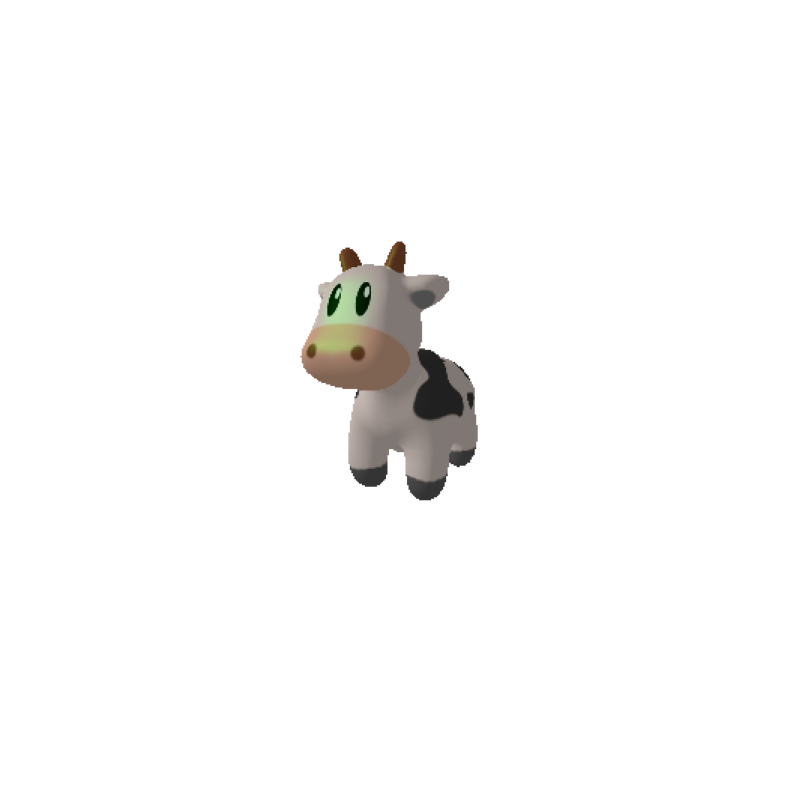

In [13]:
# Experiment 

R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)

cameras = PerspectiveCameras(device=device, R=R, T=T)

lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

materials = Materials(
 device=device,
 specular_color=[[0.0, 1.0, 0.0]],
 shininess=10.0
)

images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.savefig('green.png')
plt.show()

## Heterogenous Batches and Optimizers

### Storing multiple meshes in batches

### These meshes can be stored in Lists and Tensors

- **List format:** The vertices are represented by a list of tensors where each tensor represents 
the vertices or faces of one mesh within the mini-batch.
- **Padded format:** All the vertices are represented by one tensor and the data of the smaller 
meshes are zero-padded so that all the meshes now have the same numbers of vertices and faces.
- **Packed format:** All the vertices or faces are packed into one tensor. For each vertex or face, 
which mesh it belongs to is tracked internally. 


In [16]:
import open3d
import os
import open3d.visualization
import torch

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures.meshes import join_meshes_as_batch

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance

import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print(f"Device is CPU only! the operation will be slow")
    
mesh_names = ["cube.obj", "diamond.obj", "dodecahedron.obj"]

data_dir = "./data"

# # For Visualizing the meshes
# for mesh_name in mesh_names:
#     mesh = o3d.io.read_triangle_mesh(
#         os.path.join(data_dir, mesh_name)
#     )
#     open3d.visualization.draw_geometries(
#         [mesh],
#         mesh_show_wireframe = True, 
#         mesh_show_back_face = True
#     )

# Store all the meshes in a list
mesh_list = []
for mesh_name in mesh_names:
    mesh = load_objs_as_meshes([os.path.join(data_dir, mesh_name)], device=device)
    mesh_list.append(mesh)
    
# Create a batch of meshes
mesh_batch = join_meshes_as_batch(mesh_list, include_textures=False)

# Store the Vertices and Faces of the meshes in a list
vertex_list = mesh_batch.verts_list()
face_list = mesh_batch.faces_list()

# Storing them in padded format {In tensors}
vertex_padded = mesh_batch.verts_padded()
face_padded = mesh_batch.faces_padded()

# Storing them in padded format {In tensors}
vertex_packed = mesh_batch.verts_packed()
face_packed = mesh_batch.faces_packed()

The above meshes in `mesh_batch` can be considered to be the Ground Trurh Meshes because they are perfect. They can be considered to be the Labels which we will train our 3D Neural net against. 

We need to make slightly noiser version of the these meshes. 

In [ ]:
num_vertices = vertex_packed.shape[0]

mesh_batch_noisy = mesh_batch.clone()
# Convert motion_gt to float32
motion_gt = np.array([3., 4., 5.], dtype=np.float32)
motion_gt = torch.tensor(motion_gt, device=device)

# Convert noise and motion_estimate to float32
noise = (0.1 ** 0.5) * torch.randn(mesh_batch_noisy.verts_packed().shape, dtype=torch.float32).to(device)
noise = noise + motion_gt
mesh_batch_noisy = mesh_batch_noisy.offset_verts(noise).detach()
motion_estimate = torch.zeros(motion_gt.shape, device=device, requires_grad=True, dtype=torch.float32)

# Redefine optimizer for float32
optimizer = torch.optim.SGD([motion_estimate], lr=0.1, momentum=0.9)

# Optimization loop
for i in range(200):
    optimizer.zero_grad()
    current_mesh_batch = mesh_batch.offset_verts(motion_estimate.repeat(num_vertices, 1))
    sample_trg = sample_points_from_meshes(current_mesh_batch, 5000)
    sample_src = sample_points_from_meshes(mesh_batch_noisy, 5000)
    
    # Calculate the Chamfer distance
    loss, _ = chamfer_distance(sample_trg, sample_src)
    loss.backward()
    optimizer.step()
    
    print(f'i = {i}, motion_estimation = {motion_estimate}, loss = {loss.item()}')




i = 0, motion_estimation = tensor([0.8193, 1.0910, 1.3474], device='cuda:0', requires_grad=True), loss = 63.95668029785156
i = 1, motion_estimation = tensor([2.1333, 2.8272, 3.5076], device='cuda:0', requires_grad=True), loss = 32.58135986328125
i = 2, motion_estimation = tensor([3.4942, 4.6354, 5.7529], device='cuda:0', requires_grad=True), loss = 5.524773597717285
i = 3, motion_estimation = tensor([4.6404, 6.1701, 7.6807], device='cuda:0', requires_grad=True), loss = 2.3657097816467285
i = 4, motion_estimation = tensor([5.2661, 7.0139, 8.7795], device='cuda:0', requires_grad=True), loss = 16.535541534423828
i = 5, motion_estimation = tensor([5.2302, 6.9783, 8.8134], device='cuda:0', requires_grad=True), loss = 34.01689147949219
i = 6, motion_estimation = tensor([4.6035, 6.1561, 7.8806], device='cuda:0', requires_grad=True), loss = 33.90837097167969
i = 7, motion_estimation = tensor([3.6417, 4.8847, 6.3481], device='cuda:0', requires_grad=True), loss = 17.6402587890625
i = 8, motion_e

In [104]:
fn = lambda x : x + 10

fn_list = map(fn, [1,2,3,4])

print(list(fn_list))

[11, 12, 13, 14]
